### Test usability of the code

In [ ]:
### Import the package
import storypy as sp # check if this is used for something else
import esmvaltool
from esmvaltool.diag_scripts.shared import run_diagnostic, get_cfg, group_metadata
from esmvaltool.diag_scripts.shared._base import _get_input_data_files
import pandas as pd
import xarray as xr
import numpy as np

In [2]:

def parse_config(file):
    """Parse the settings file."""
    config = get_cfg(file)           
    config['input_data'] = _get_input_data_files(config)
    return config

In [ ]:
user_config = dict(
    # Choose region selection method: 'box' or 'mask'
    region_method = 'box',  # Set to 'box' or 'mask'
    # Define the bounding box for the desired region if using 'box'
    box = {
        'lon_min': 10, 'lon_max': 20,  # Example region
        'lat_min': 40, 'lat_max': 50
    },
    # Define the region_id for regionmask if using 'mask'
    #region_id = int(input("Please enter a region ID from the list of IPCC region list: "))
    region_id = 18,  # Adjusted region ID
    season = "DJF"  # Specify the season here (e.g., "DJF" for winter)
)

config= parse_config('/climca/people/ralawode/esmvaltool_output/full_storyline_analysis_complete_20240923_140137/run/multiple_regression_indices/multiple_regresion/settings.yml')
#with run_diagnostic() as config:
cs.main(config, user_config)

In [ ]:
rds = pd.read_csv("/climca/people/jmindlin/esmvaltool_output/zappa_shepherd_CMIP6_20241204_165252/work/multiple_regression_indices/multiple_regresion/remote_drivers/scaled_standardized_drivers.csv", index_col=0)
models = rds.index.tolist()
cs.plot_ellipse(models,rds["spv"].values,rds["ta"].values,corr="no",x_label="Tropical Warming",y_label="Stratospheric Polar Vortex")

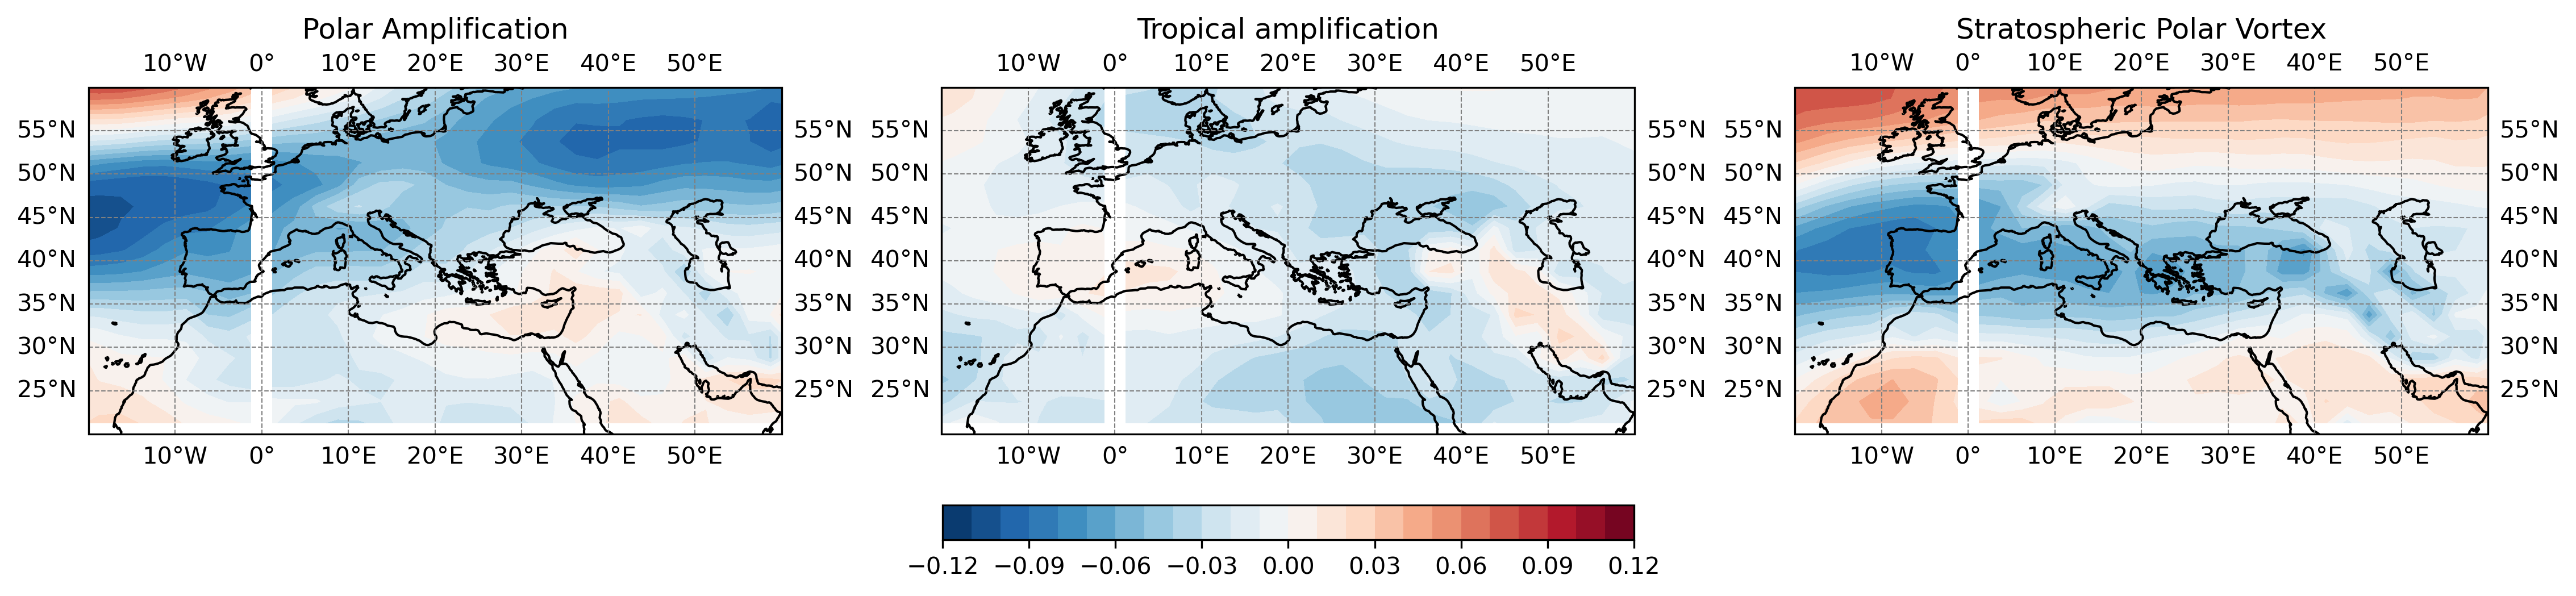

In [2]:
folder = '/climca/people/jmindlin/esmvaltool_output/zappa_shepherd_CMIP6_20241204_165252/work/multiple_regression_indices'
data = xr.open_dataset(folder+'/multiple_regresion/regression_output/ua/regression_coefficients.nc').sel(lat=slice(-88,88)) 
coefficients = [ data.pw, data.ta, data.spv ]
levels = [np.arange(-.12,.13,.01)] * 3
extent = [[-20,60,20,60]] * 3
cmaps = ['RdBu_r'] * 3
titles = ['Polar Amplification','Tropical amplification','Stratospheric Polar Vortex']
fig = cs.plotting.create_three_panel_figure(coefficients, extent, levels, cmaps, titles)

In [ ]:
import storypy as sp
import xarray as xr
import pkg_resources
from storypy.data import read_pr_R2, read_ua_R2, read_drivers, read_ua_regression_coefficients_relative_importance



/tmp/ipykernel_1937032/2196782031.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


"\ndef read_data():\n    data_path = pkg_resources.resource_filename('storypy', 'data/regression_output/ua/regression_coefficients_pvalues.nc')\n    data = xr.open_dataset(data_path)\n    return data\n"

In [3]:
# read_data()

driver = read_pr_R2()
print(driver)

<xarray.Dataset> Size: 85kB
Dimensions:  (lat: 72, lon: 144)
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Data variables:
    pr       (lat, lon) float64 83kB ...
